Building our own Convolutional Neural Network from scratch.

This blog post is a code-first introduction to Convolutional Networks (ConvNets). We will build our own ConvNet from scratch and understand the fundamentals of how and why they work so well, particularly for image processing tasks.

NB: This blog uses some functions from the [little_ai](https://github.com/darkknightxi/little_ai) library I am currently building.   

# Importing Libraries

In [1]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from little_ai.training import *
from little_ai.datasets import *

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from urllib.request import urlretrieve
from torch import tensor
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader
from typing import Mapping

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Why ConvNets

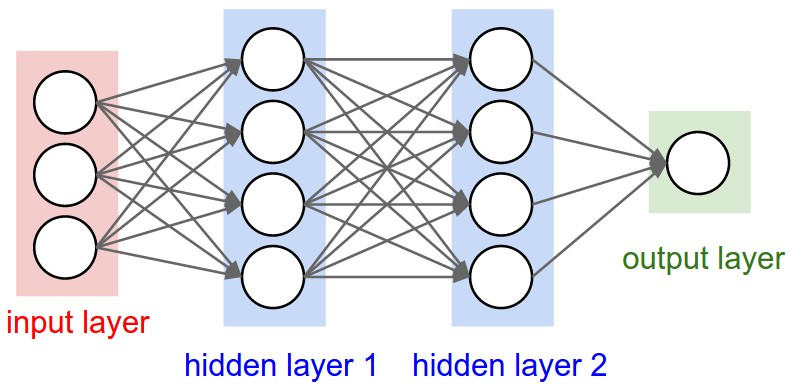
> Figure 1: A simple neural net with two hidden layers

Images have properties that necessitate the need for specialized architectures.

- They are high-dimensional. RGB images of dimensions $224\times224$ are very common (i.e., $150, 528$ input dimensions). Hidden layers in fully connected networks are generally larger than the input size, so even for a shallow network, the number of weights would exceed $150,528^2$ or $22$ billion. This poses obvious practical problems in terms of the required training data, memory, and computation.
- Nearby image pixels are statistically related. However, fully connected networks have no notion of "nearby" and treat the relation between every input equally.
- The interpretation of an image is stable under geometric transformations. An image of a tree is still an image of a tree if we shift it leftwards by a few pixels. However, this shift is stable under geometric transformations. Hence, a fully connected model must learn the patterns of pixels that signify a tree separately at every position, which is inefficient.

Convolutional layers process each local image region independently, using parameters shared across the whole image. They use fewer parameters than fully connected layers, exploit the spatial relationships between nearby pixels, and don't have to re-learn the interpretation of pixels at every position.

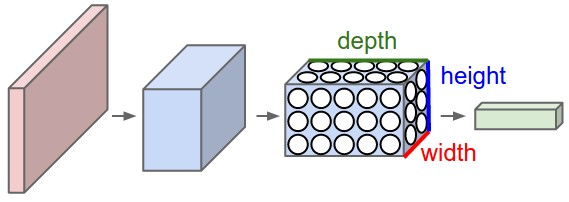
> Figure 2: Architecture of a simple ConvNet

# Convolution Operation

Convolutional layers perform the convolution operation using kernels (or filters) which is simply a matrix, over an image. Convolution is a simple mathematical operation that involves addition and multiplication.

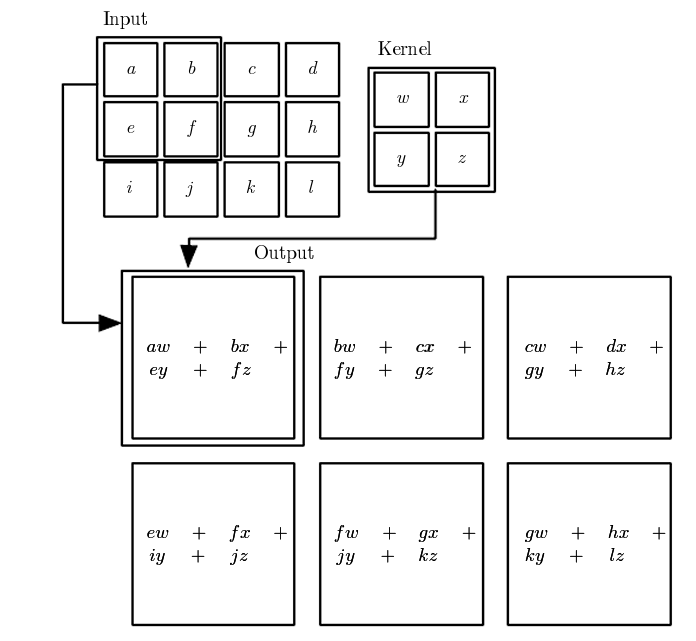

> Figure 3: Convolution operation using a $2\times2$ kernel over a $3\times4$ image that results in a $2\times3$ output matrix. The kernel slides over the image, adding the products of the overlapping matrix values. Source: [Deep Learning](https://www.deeplearningbook.org) by Goodfellow, et al.

Now, let's implement our own convolution operation using numpy.
We'll choose an image from the training set and create a simple $3\times 3$ matrix as our kernel and, as we'll see,  the convolution operation with the right choice of the kernel will be able to identify some pattern in our image.

In [5]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [6]:
mpl.rcParams['figure.dpi'] = 30

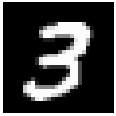

In [7]:
im3 = x_imgs[7]
show_image(im3);

Let's create a simple $3\times3$ kernel (people in the computer vision world call it a kernel; essentially it's just a tensor). 

NB: Actually, the values of kernels are not entered manually but are learned as parameters during training. 

In [8]:
top_edge = tensor([[-1, -1, -1], 
                  [0, 0, 0], 
                  [1, 1, 1]]).float()

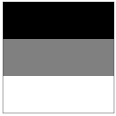

In [9]:
show_image(top_edge, noframe=False);

This kernel will slide along all the $3\times 3$ windows in our images and compute the convolutions. 
If  $3\times 3$` window looks like this:

$$\begin{matrix} a & b & c \\ d & e & f \\ g & h & i\end{matrix}$$

then the result will be $-a -b -c +g+h+i$

In [10]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


If we compute the convolution over the $3\times 3$ window along rows $3$ to $5$ and columns $14$ to $16$ (the top edge of the $3$), the result will be:

In [11]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

Similarly, doing this in the window made by rows $7, 8, 9$ and columns $14, 15, 16$ (the bottom edge of $3$), we'll get:

In [12]:
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

The positive pixels represent the "lighter" pixels and negative values represent the "darker" pixels in relative terms. Our kernel should be able to highlight the top edges of $3$ by making the top edges lighter and the bottom edges darker.

Note that to compute the convolutions, we are simply doing numpy's element-wise multiplication followed by a sum.

Let's create a function which will compute the the convolutions over any $3 \times 3$ window with any $3 \times 3$ kernel.

In [13]:
#row and col define the center coordinate of a 3x3 window
def apply_kernel(row, col, kernel): return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [14]:
apply_kernel(4, 15, top_edge)

tensor(2.9727)

Next, we want to slide this kernel over the entire image. To do this, we'll use list comprehension inside a list comprehension to create coordinates over which we want to move.

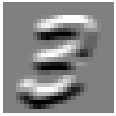

In [15]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3);

Our simple little $3 \times 3$ kernel has managed to highlight the top edges of the digit $3$ !

Here's a subtle thing that we need to notice.

In [16]:
top_edge3.shape

torch.Size([26, 26])

The shape of the output image is $26\times 26$ while the input image had $28\times 28$ dimensions. It is easy to see why the output dimensions change if we visualize the kernel sliding over all the $3\times 3$ windows in our input image. In general, if a kernel of dimension $f\times f$ convolve over an image of dimension $N\times N$, the output will have dimensions $(N-f+1)\times (N-f+1)$.

Let's repeat the same exercise using another kernel which should be able to highlight the left edges.

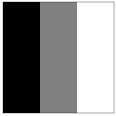

In [17]:
left_edge = tensor([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]).float()
show_image(left_edge, noframe=False);

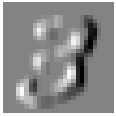

In [18]:
left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge3);

And it works as expected.

# Convolutions in PyTorch

The convolutions that we implemented in python above are quite slow.

In [19]:
%timeit -n 1 tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])

9.7 ms ± 5.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


PyTorch has an `Conv2d` class that is optimized for convolutions and offers added features and benefits.

In [20]:
inp = im3[None,None,:,:].float()

`conv2d` expects the input image to be a rank-four tensor where the dimensions correspond to `batch, channel, height, width` respectively. Since we are only considering a single image, our batch size (first dimension) is one, and we are working with black-and-white images, our images have a single channel. Colored images have three channels: red, green, and blue.  

In [21]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 479.87 times longer than the fastest. This could mean that an intermediate result is being cached.
887 µs ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Convolutions over a batch of images

When training our network, we pass the input images to the models as batches. `conv2d` allows us to conveniently implement the convolutions using multiple kernels simultaneously over a batch of images.

Let's make two more kernels to detect diagnals in the image. 

In [22]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

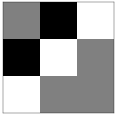

In [23]:
show_image(diag1_edge, noframe=False);

In [24]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

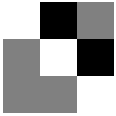

In [25]:
show_image(diag2_edge);

Let's create a batch of 16 images.

In [26]:
xb = x_imgs[:16][:, None]
xb.shape

torch.Size([16, 1, 28, 28])

And stack all our kernels together

In [27]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

Now, we pass the batch and kernel to `conv2d`

In [28]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

The output indicates that we have $16$ images in the batch, $4$ filters, and each image is of dimension $26\times26$.

Let's see what the kernels detect when applied on a particular image

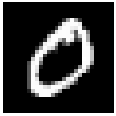

In [29]:
x = xb[1, 0]
show_image(x);

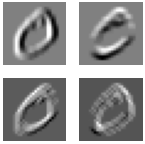

In [30]:
show_images([batch_features[1,i] for i in range(4)]);

# Strides and Padding

Using the convolution operation, we lose some pixels from our image, effectively losing data, which is never good. Using appropriate padding, we can ensure that the output activation map is the same size as the input image.
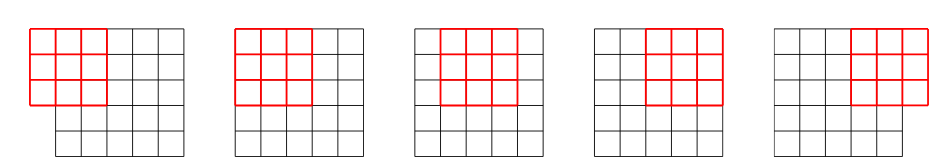
>Figure 4: Padding

Zero padding is a common approach where the input outside the valid range is $0$. If we pad the images so that the output dimensions are the same as the input dimensions, then it's called valid padding. If we add a kernel of size $f\times f$ (with $f$ an odd number), the necessary padding on each side to keep the same shape is $f//2$.

So far, we've seen our kernel slide over the image grid by one unit, or in other words, it has a *stride* of 1. However, a kernel can have a stride greater than $1$ as well. A stride of 2 means creating roughly half the number of outputs.

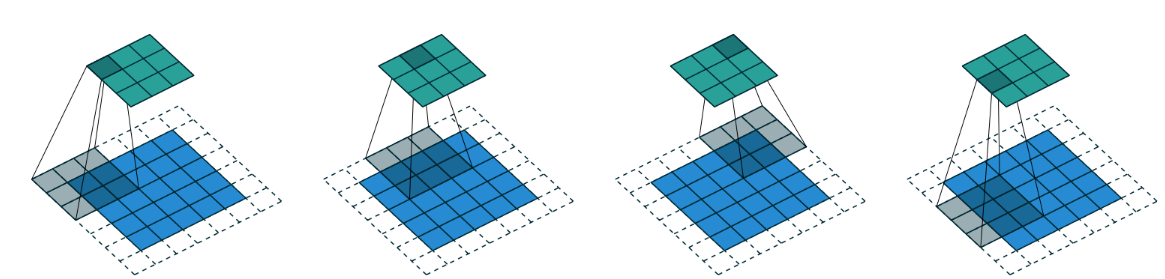
> Figure 5: stride-2 convolutions


If we have an image of size $n\times n$, a kernel of size $f\times f$, padding of $p$ pixels on each side, and a stride of $s$ then the output of the convolution operation will have a size of $(\frac{n-f+2p}{s} + 1) \times (\frac{n-f+2p}{s} + 1)$.

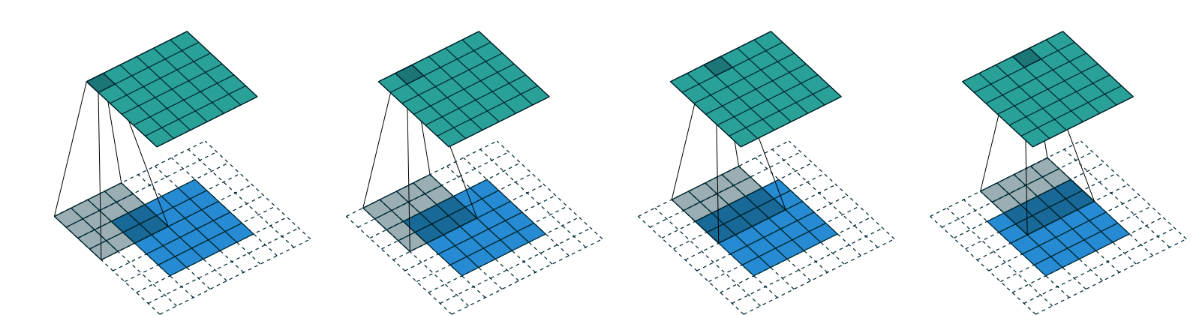
> Figure 6: With a $5\times 5$ input, $4\times 4$ kernel, and $2$ pixels of padding, we end up with a $6\times 6$ activation map.

# Creating a CNN

We are now able to create and train a Convolutional Neural Network. But before that, let's recall how we'd build a simple one-layer MLP using `nn.Sequential`.

In [31]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [32]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

What if we use the same idea to build a CNN as well.

In [33]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 10, kernel_size=3, padding=1)
)

In [34]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

We want to have 10 output channels for each of the 16 images in the batch which isn't the case here.

To make our ConvNet architecture, we'll first create a `conv` function with appropriate input channels, output channels, stride, kernel size, and padding which returns a sequential model with an optional activation function.

In [35]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

and then put those `conv` functions together to get our ConvNet architecture. The `nn.Flatten()` removes the unneccesary unit axes. The commented dimensions represent the dimensions of the output from that conv layer.

In [36]:
simple_cnn = nn.Sequential(
    conv(1, 4),                 #14x14
    conv(4, 8),                 #7x7
    conv(8, 16),                #4x4
    conv(16, 16),               #2x2
    conv(16, 10, act=False),    #1x1
    nn.Flatten()
)

In [37]:
simple_cnn(xb).shape

torch.Size([16, 10])

Now lets create our Datasets and DataLoaders to create batches for training.

In [38]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [39]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [40]:
bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

Notice that we move our model (and its parameters) to the gpu (if its available) to speed up training.

We'll be using accuracy as a metric.

Let's call `fit` and train for 5 epochs.

In [41]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

epoch:0, loss:0.9480767825126648, accuracy:0.715
epoch:1, loss:0.26140550297498705, accuracy:0.9215
epoch:2, loss:0.20503890758752824, accuracy:0.9388
epoch:3, loss:0.13651981556415557, accuracy:0.9597
epoch:4, loss:0.12075043138265609, accuracy:0.9665


and it seems to be working fine.

Now let's reduce the learning rate to 0.1 and train again for 5 epochs.

In [42]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

epoch:0, loss:0.09355406395196915, accuracy:0.9733
epoch:1, loss:0.08985215668007732, accuracy:0.9746
epoch:2, loss:0.08949725909978151, accuracy:0.9743
epoch:3, loss:0.08952338592857123, accuracy:0.9743
epoch:4, loss:0.10270511233061552, accuracy:0.9697


... and accuracy has improved to 0.97!

That was all about building and training ConvNets from the ground up. 


Thankyou for reading. 